In [1]:
import os
import sys
#path environment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import traci

import xml.etree.ElementTree as ET

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import numpy as np

import random
import time

In [2]:
file_output = 'my_output_file_grid_dinamico_delay.xml'
sumo_cmd = ['sumo', 
            '--duration-log.statistics', 
            '--tripinfo-output', file_output, 
            '-c', 'maps/grid/grid.sumo.cfg']

In [3]:
def reroute_vehicle(vehicle_id):
    try:
        current_edge = traci.vehicle.getRoadID(vehicle_id)
        
        # Get the current route of the vehicle
        current_route = traci.vehicle.getRoute(vehicle_id)

        if current_edge not in current_route:
            # If the current edge is not in the route, dynamically find a new route
            print(f"Warning: Vehicle {vehicle_id} is not on a known route edge. Attempting to reroute.")
            
            # Attempt to find a new route to the destination
            destination = traci.vehicle.getRoute(vehicle_id)[-1]
            new_route = traci.simulation.findRoute(current_edge, destination).edges

            if new_route:
                traci.vehicle.setRoute(vehicle_id, new_route)
                print(f"Vehicle {vehicle_id} rerouted to new path: {new_route}")
            return

        current_index = current_route.index(current_edge)
        
        # Initialize variables to store the best alternative route
        best_route = current_route
        min_time_loss = float('inf')

        # Fetch alternative routes starting from the current edge
        for edge in current_route[current_index:]:
            # Check if edge is less congested
            edge_density = traci.edge.getLastStepVehicleNumber(edge) / traci.edge.getLaneNumber(edge)
            if edge_density < 0.5:  # Example threshold for low congestion
                # Estimate time loss on this route
                time_loss = sum(traci.edge.getTraveltime(e) for e in current_route[current_index:])
                
                # Update best route if this one has lower time loss
                if time_loss < min_time_loss:
                    min_time_loss = time_loss
                    best_route = current_route[current_index:]

        # Set the new route if it's different and has less time loss
        if best_route != current_route:
            traci.vehicle.setRoute(vehicle_id, best_route)

    except traci.exceptions.TraCIException as e:
        print(f"TraCIException for vehicle {vehicle_id}: {str(e)}")
    except ValueError as e:
        print(f"ValueError for vehicle {vehicle_id}: {str(e)}")

# Use the function in your simulation loop


In [4]:
# Dicionário para armazenar o estado de comunicação de cada veículo
vehicle_communication_state = {}

def communication_delay_func(vehicle_id, communication_delay=5, processing_time=3):

    current_time = traci.simulation.getTime()

    # Inicializar o estado de comunicação para o veículo, se não existir
    if vehicle_id not in vehicle_communication_state:
        vehicle_communication_state[vehicle_id] = {
            'last_info_time': current_time,
            'is_processing': False
        }

    comm_state = vehicle_communication_state[vehicle_id]

    # Verificar se o veículo ainda está processando a informação
    if comm_state['is_processing']:
        # Verifica se o tempo de processamento acabou
        if current_time - comm_state['last_info_time'] >= processing_time:
            comm_state['is_processing'] = False
        else:
            # Veículo ainda está processando, não faz reroteamento
            return

    # Simula o atraso na comunicação
    if current_time - comm_state['last_info_time'] < communication_delay:
        # Ainda aguardando o recebimento de informações
        return

    # Atualiza o tempo de recebimento da última informação
    comm_state['last_info_time'] = current_time
    comm_state['is_processing'] = True

    reroute_vehicle(vehicle_id)

In [5]:
# Exemplo de loop de simulação com implementação de atraso
def run_simulation(communication_delay=5, processing_time=3):
    # Iniciar o SUMO e o TraCI
    traci.start(sumo_cmd)
    
    step = 0
    try:
        while step < STEPTOTAL:  # Simular por 3600 segundos (1 hora)
            traci.simulationStep()

            for vehicle_id in traci.vehicle.getIDList():
                communication_delay_func(vehicle_id, communication_delay=communication_delay, processing_time=processing_time)

            step += 1
    finally:
        traci.close()

In [6]:
def analyze_time_loss(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Initialize variables for analysis
    total_time_loss = 0.0
    total_waiting_time = 0.0
    total_duration = 0.0
    total_reroutes = 0
    vehicle_count = 0

    # Iterate over each tripinfo element in the XML
    for trip in root.findall('tripinfo'):
        time_loss = float(trip.get('timeLoss'))
        waiting_time = float(trip.get('waitingTime'))
        duration = float(trip.get('duration'))
        reroutes = int(trip.get('rerouteNo'))
        
        total_time_loss += time_loss
        total_waiting_time += waiting_time
        total_duration += duration
        total_reroutes += reroutes
        vehicle_count += 1

    # Calculate averages
    average_time_loss = total_time_loss / vehicle_count if vehicle_count > 0 else 0
    average_waiting_time = total_waiting_time / vehicle_count if vehicle_count > 0 else 0
    average_duration = total_duration / vehicle_count if vehicle_count > 0 else 0
    average_reroutes = total_reroutes / vehicle_count if vehicle_count > 0 else 0

    # Store results in a dictionary
    results = {
        'Total Vehicles': vehicle_count,
        'Total Time Loss': total_time_loss,
        'Average Time Loss': average_time_loss,
        'Total Waiting Time': total_waiting_time,
        'Average Waiting Time': average_waiting_time,
        'Average Duration': average_duration,
        'Total Reroutes': total_reroutes,
        'Average Reroutes': average_reroutes
    }
    return results


In [7]:
# reroute_intervals = [5,10,15,20,30,40,50, 60, 120]  # Different intervals to test
reroute_intervals = [5,10,20,30,60,90,120]  # Different intervals to test
processing_times = [0,5,10,15]
STEPTOTAL = 3600
simulation_results = []

for reroute_interval in reroute_intervals:
    for processing_time in processing_times:
        print(f"Running simulation with reroute interval: {reroute_interval} seconds with processing_time: {processing_time} seconds")
    
        run_simulation(reroute_interval, processing_time)
        
        # Analyze the results and store them in the simulation_results list
        results = analyze_time_loss(file_output)
        results['communication_delay'] = reroute_interval  # Add the interval as a data point
        results['processing_time'] = processing_time  # Add the interval as a data point
        simulation_results.append(results)



Running simulation with reroute interval: 5 seconds with processing_time: 0 seconds
 Retrying in 1 seconds
***Starting server on port 33911 ***
Loading net-file from 'maps/grid/grid.net.xml' ... done (11ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Vehicle 1 rerouted to new path: (':B3_19', 'B3B2', 'B2B1', 'B1B0')
Vehicle 7 rerouted to new path: (':E0_1', 'E0E1', 'E1E2', 'E2E3', 'E3D3', 'D3C3', 'C3C2')
Vehicle 9 rerouted to new path: (':C4_0', 'C4B4', 'B4B3', 'B3B2', 'B2B1', 'B1B0', 'B0A0', 'A0A1')
Vehicle 16 rerouted to new path: (':B3_7', 'B3C3', 'C3D3', 'D3E3', 'E3E4')
Vehicle 15 rerouted to new path: (':C4_10', 'C4D4', 'D4D3', 'D3D2', 'D2D3')
Vehicle 0 rerouted to new path: (':E1_10', 'E1D1', 'D1C1', 'C1B1', 'B1A1', 'A1A0')
Vehicle 2 rerouted to new path: (':D2_1', 'D2D1', 'D1D2')
Vehicle 3 rerouted to new path: (':D2_5', 'D2C2', 'C2B2', 'B2A2', 'A2A3')
Vehicle 23 rerouted to new path: (':A2_9', 'A2B2', 'B2B3')
Vehicle 24 rerouted to new path: (':D1_9', 'D1D

In [8]:
# Convert results to a DataFrame
df = pd.DataFrame(simulation_results)
df

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,communication_delay,processing_time
0,4350,192322.09,44.211975,89564.0,20.589425,116.607356,27,0.006207,5,0
1,4356,201791.98,46.325064,96568.0,22.168962,118.806244,0,0.000000,5,5
2,4356,190172.31,43.657555,88698.0,20.362259,116.093205,0,0.000000,5,10
3,4362,187663.55,43.022364,85518.0,19.605227,115.522925,0,0.000000,5,15
4,4359,194676.70,44.660863,90393.0,20.737096,117.231246,0,0.000000,10,0
5,4360,188057.42,43.132436,85819.0,19.683257,115.642890,0,0.000000,10,5
6,4350,193228.10,44.420253,90131.0,20.719770,116.954483,0,0.000000,10,10
7,4350,183907.28,42.277536,83546.0,19.205977,114.795632,0,0.000000,10,15
8,4353,183857.10,42.236871,83129.0,19.096945,114.826097,0,0.000000,20,0
9,4353,183857.10,42.236871,83129.0,19.096945,114.826097,0,0.000000,20,5


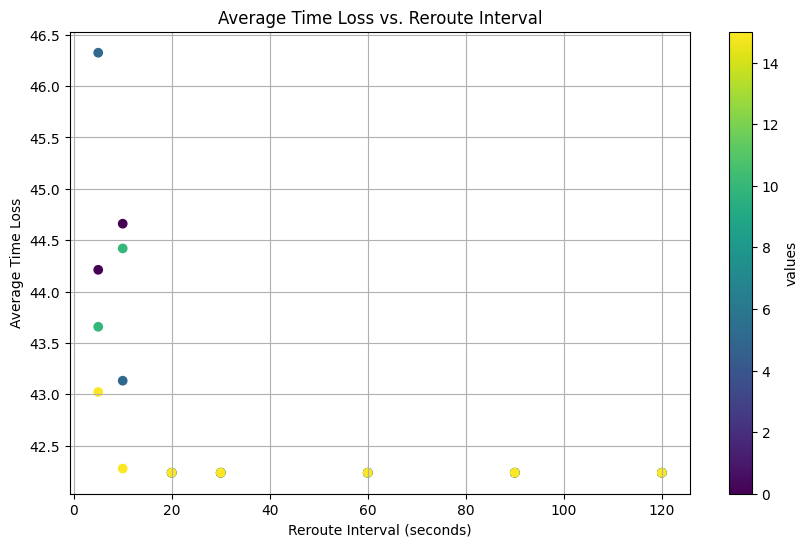

In [9]:


plt.figure(figsize=(10, 6))
plt.scatter(df['communication_delay'], df['Average Time Loss'],c = df['processing_time'], marker='o')
plt.colorbar(label="values")
plt.title('Average Time Loss vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)
plt.show()


In [10]:
# Display descriptive statistics
df.describe()

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,communication_delay,processing_time
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.00000
mean,4353.678571,186034.336786,42.730195,84743.464286,19.464674,115.291997,0.964286,0.000222,47.857143,7.50000
std,2.708745,4461.694687,1.016201,3305.208342,0.755650,0.981508,5.102520,0.001173,41.263125,5.69275
min,4350.000000,183857.100000,42.236871,83129.000000,19.096945,114.795632,0.000000,0.000000,5.000000,0.00000
25%,4353.000000,183857.100000,42.236871,83129.000000,19.096945,114.826097,0.000000,0.000000,10.000000,3.75000
50%,4353.000000,183857.100000,42.236871,83129.000000,19.096945,114.826097,0.000000,0.000000,30.000000,7.50000
75%,4353.000000,184846.347500,42.463743,84039.000000,19.305789,115.000304,0.000000,0.000000,90.000000,11.25000
max,4362.000000,201791.980000,46.325064,96568.000000,22.168962,118.806244,27.000000,0.006207,120.000000,15.00000


In [11]:
# Specific statistics for each reroute interval
grouped_stats = df[['communication_delay',"processing_time","Average Time Loss","Average Duration","Average Waiting Time"]]\
                .groupby(['communication_delay',"processing_time"]).agg(['mean','min', 'max'])
grouped_stats

Average Time Loss                        \
                                                 mean        min        max   
communication_delay processing_time                                           
5                   0                       44.211975  44.211975  44.211975   
                    5                       46.325064  46.325064  46.325064   
                    10                      43.657555  43.657555  43.657555   
                    15                      43.022364  43.022364  43.022364   
10                  0                       44.660863  44.660863  44.660863   
                    5                       43.132436  43.132436  43.132436   
                    10                      44.420253  44.420253  44.420253   
                    15                      42.277536  42.277536  42.277536   
20                  0                       42.236871  42.236871  42.236871   
                    5                       42.236871  42.236871  42.236871   
                    10                      42.236871  42.236871  42.236871   
                    15                      42.236871  42.236871  42.236871   
30                  0                       42.236871  42.236871  42.236871   
                    5                       42.236871  42.236871  42.236871   
                    10                      42.236871  42.236871  42.236871   
                    15                      42.236871  42.236871  42.236871   
60                  0                       42.236871  42.236871  42.236871   
                    5                       42.236871  42.236871  42.236871   
                    10                      42.236871  42.236871  42.236871   
                    15                      42.236871  42.236871  42.236871   
90                  0                       42.236871  42.236871  42.236871   
                    5                       42.236871  42.236871  42.236871   
                    10                      42.236871  42.236871  42.236871   
                    15                      42.236871  42.236871  42.236871   
120                 0                       42.236871  42.236871  42.236871   
                    5                       42.236871  42.236871  42.236871   
                    10                      42.236871  42.236871  42.236871   
                    15                      42.236871  42.236871  42.236871   

                                    Average Duration                          \
                                                mean         min         max   
communication_delay processing_time                                            
5                   0                     116.607356  116.607356  116.607356   
                    5                     118.806244  118.806244  118.806244   
                    10                    116.093205  116.093205  116.093205   
                    15                    115.522925  115.522925  115.522925   
10                  0                     117.231246  117.231246  117.231246   
                    5                     115.642890  115.642890  115.642890   
                    10                    116.954483  116.954483  116.954483   
                    15                    114.795632  114.795632  114.795632   
20                  0                     114.826097  114.826097  114.826097   
                    5                     114.826097  114.826097  114.826097   
                    10                    114.826097  114.826097  114.826097   
                    15                    114.826097  114.826097  114.826097   
30                  0                     114.826097  114.826097  114.826097   
                    5                     114.826097  114.826097  114.826097   
                    10                    114.826097  114.826097  114.826097   
                    15                    114.826097  114.826097  114.826097   
60                  0                     114.826097  114.826097  

In [12]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix
correlation_matrix

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,communication_delay,processing_time
Total Vehicles,1.000000,0.325769,0.301911,0.284210,0.269098,0.301907,-0.266150,-0.266150,-2.582276e-01,-6.004625e-03
Total Time Loss,0.325769,1.000000,0.999684,0.996747,0.995928,0.998924,0.276192,0.276192,-5.010223e-01,-1.922364e-01
Average Time Loss,0.301911,0.999684,1.000000,0.997509,0.997086,0.999224,0.285772,0.285772,-4.984046e-01,-1.936449e-01
Total Waiting Time,0.284210,0.996747,0.997509,1.000000,0.999876,0.995203,0.285833,0.285833,-5.025306e-01,-1.783231e-01
Average Waiting Time,0.269098,0.995928,0.997086,0.999876,1.000000,0.994760,0.291710,0.291710,-5.006497e-01,-1.790010e-01
Average Duration,0.301907,0.998924,0.999224,0.995203,0.994760,1.000000,0.262643,0.262643,-4.869499e-01,-1.982206e-01
Total Reroutes,-0.266150,0.276192,0.285772,0.285833,0.291710,0.262643,1.000000,1.000000,-2.035525e-01,-2.581989e-01
Average Reroutes,-0.266150,0.276192,0.285772,0.285833,0.291710,0.262643,1.000000,1.000000,-2.035525e-01,-2.581989e-01
communication_delay,-0.258228,-0.501022,-0.498405,-0.502531,-0.500650,-0.486950,-0.203552,-0.203552,1.000000e+00,-8.962562e-17
processing_time,-0.006005,-0.192236,-0.193645,-0.178323,-0.179001,-0.198221,-0.258199,-0.258199,-8.962562e-17,1.000000e+00


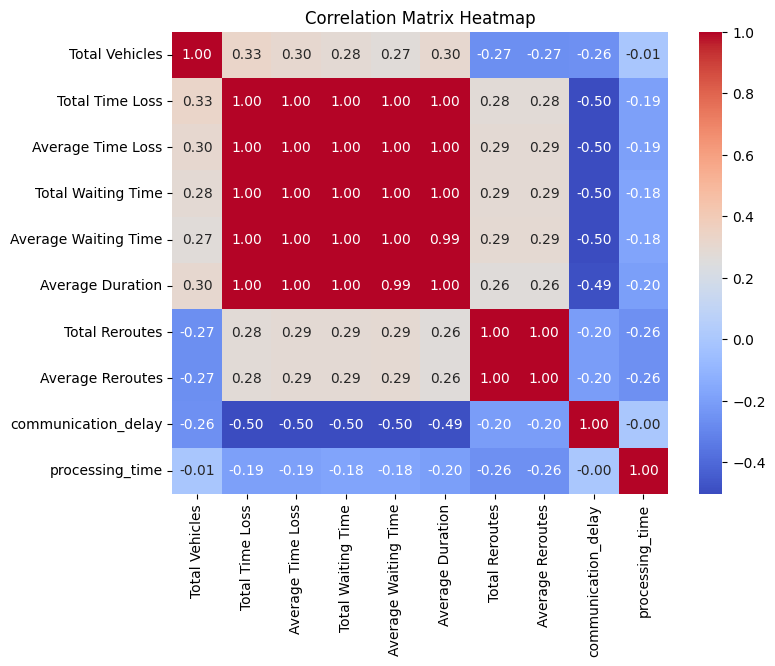

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


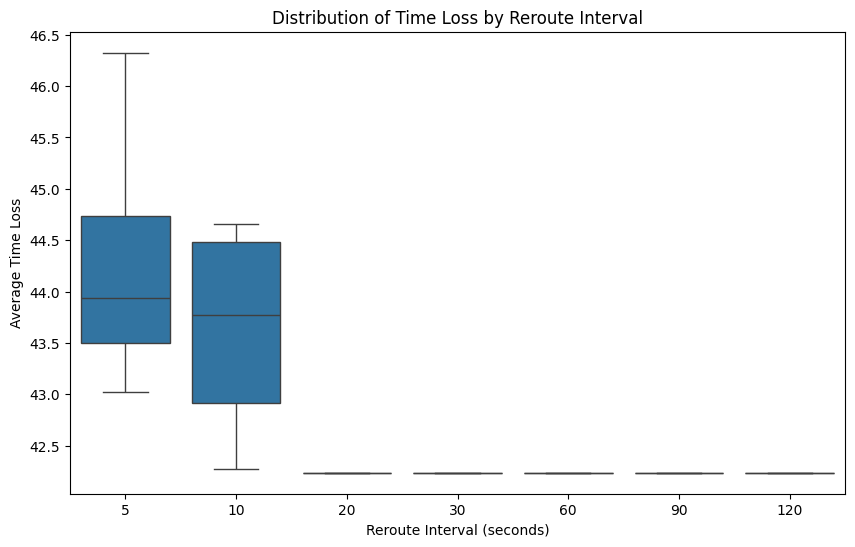

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='communication_delay', y='Average Time Loss', data=df)
plt.title('Distribution of Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.show()


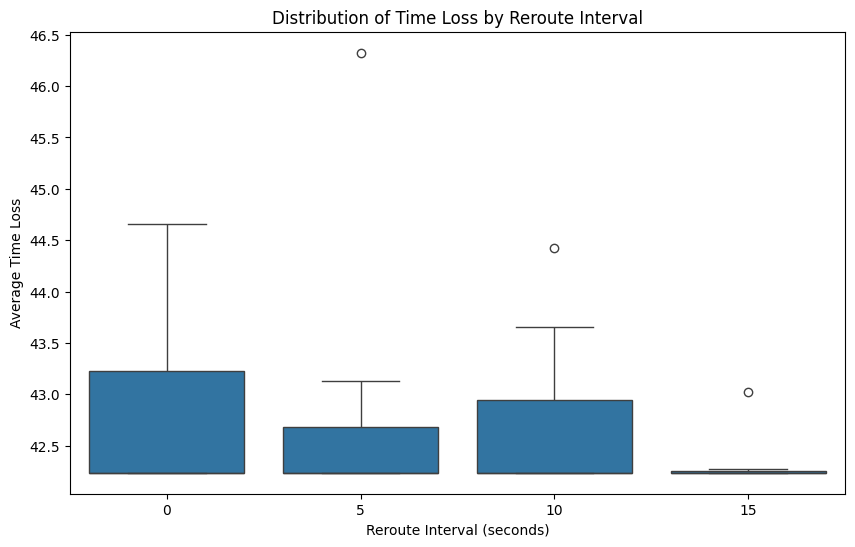

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="processing_time", y='Average Time Loss', data=df)
plt.title('Distribution of Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.show()

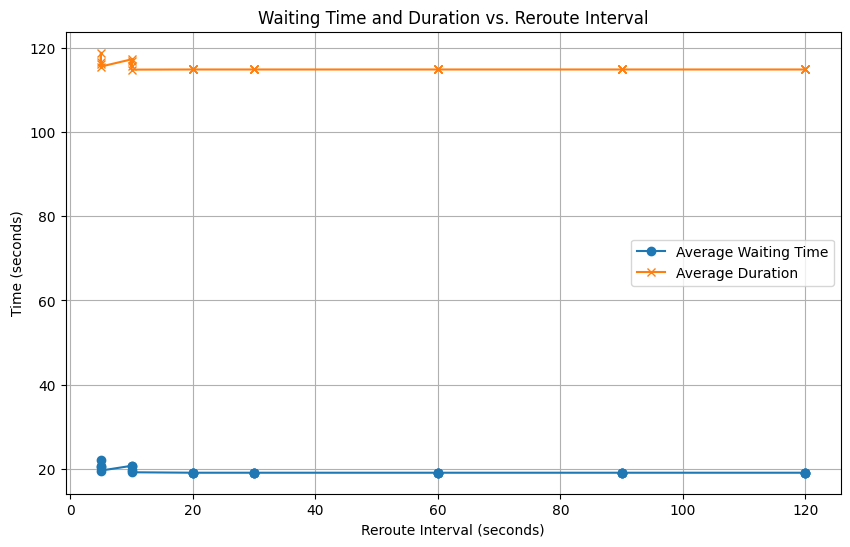

In [16]:
# Plot waiting time vs reroute interval
plt.figure(figsize=(10, 6))
plt.plot(df['communication_delay'], df['Average Waiting Time'], marker='o', label='Average Waiting Time')
plt.plot(df['communication_delay'], df['Average Duration'], marker='x', label='Average Duration')
plt.title('Waiting Time and Duration vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


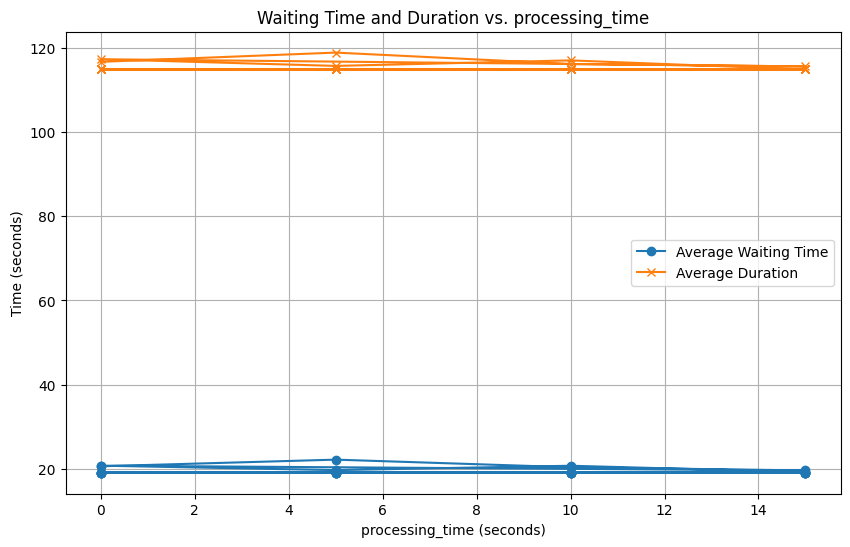

In [17]:
# Plot waiting time vs reroute processing_time
plt.figure(figsize=(10, 6))
plt.plot(df['processing_time'], df['Average Waiting Time'], marker='o', label='Average Waiting Time')
plt.plot(df['processing_time'], df['Average Duration'], marker='x', label='Average Duration')
plt.title('Waiting Time and Duration vs. processing_time')
plt.xlabel('processing_time (seconds)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


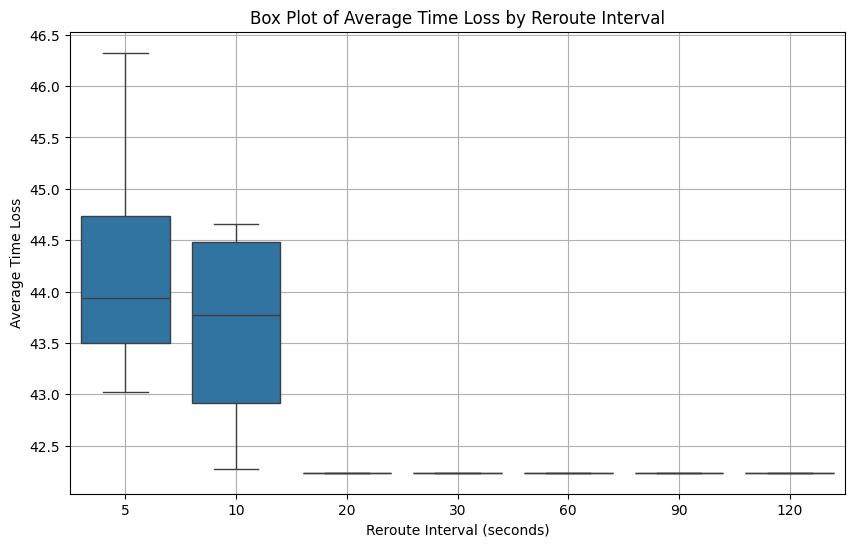

In [18]:
# Create a box plot for Average Time Loss vs. Reroute Interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='communication_delay', y='Average Time Loss', data=df)
plt.title('Box Plot of Average Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)

# Show the plot
plt.show()

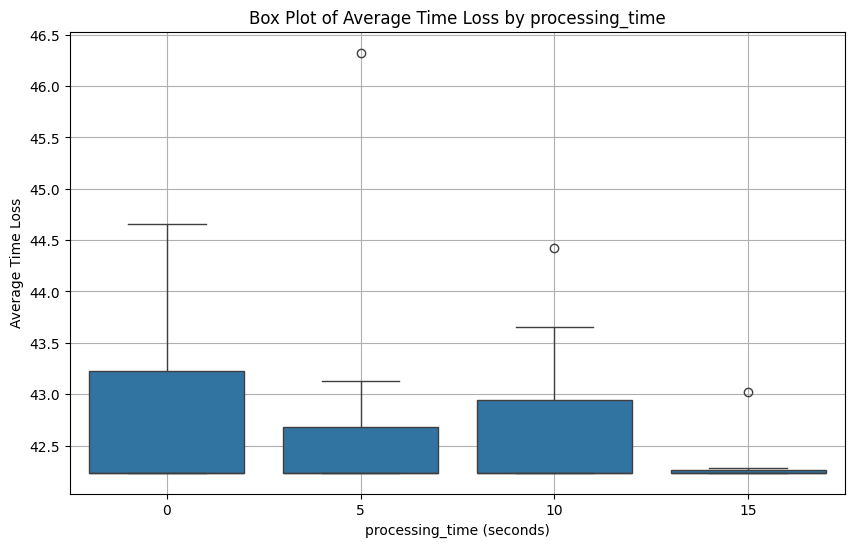

In [19]:
# Create a box plot for Average Time Loss vs. Reroute Interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='processing_time', y='Average Time Loss', data=df)
plt.title('Box Plot of Average Time Loss by processing_time')
plt.xlabel('processing_time (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)

# Show the plot
plt.show()

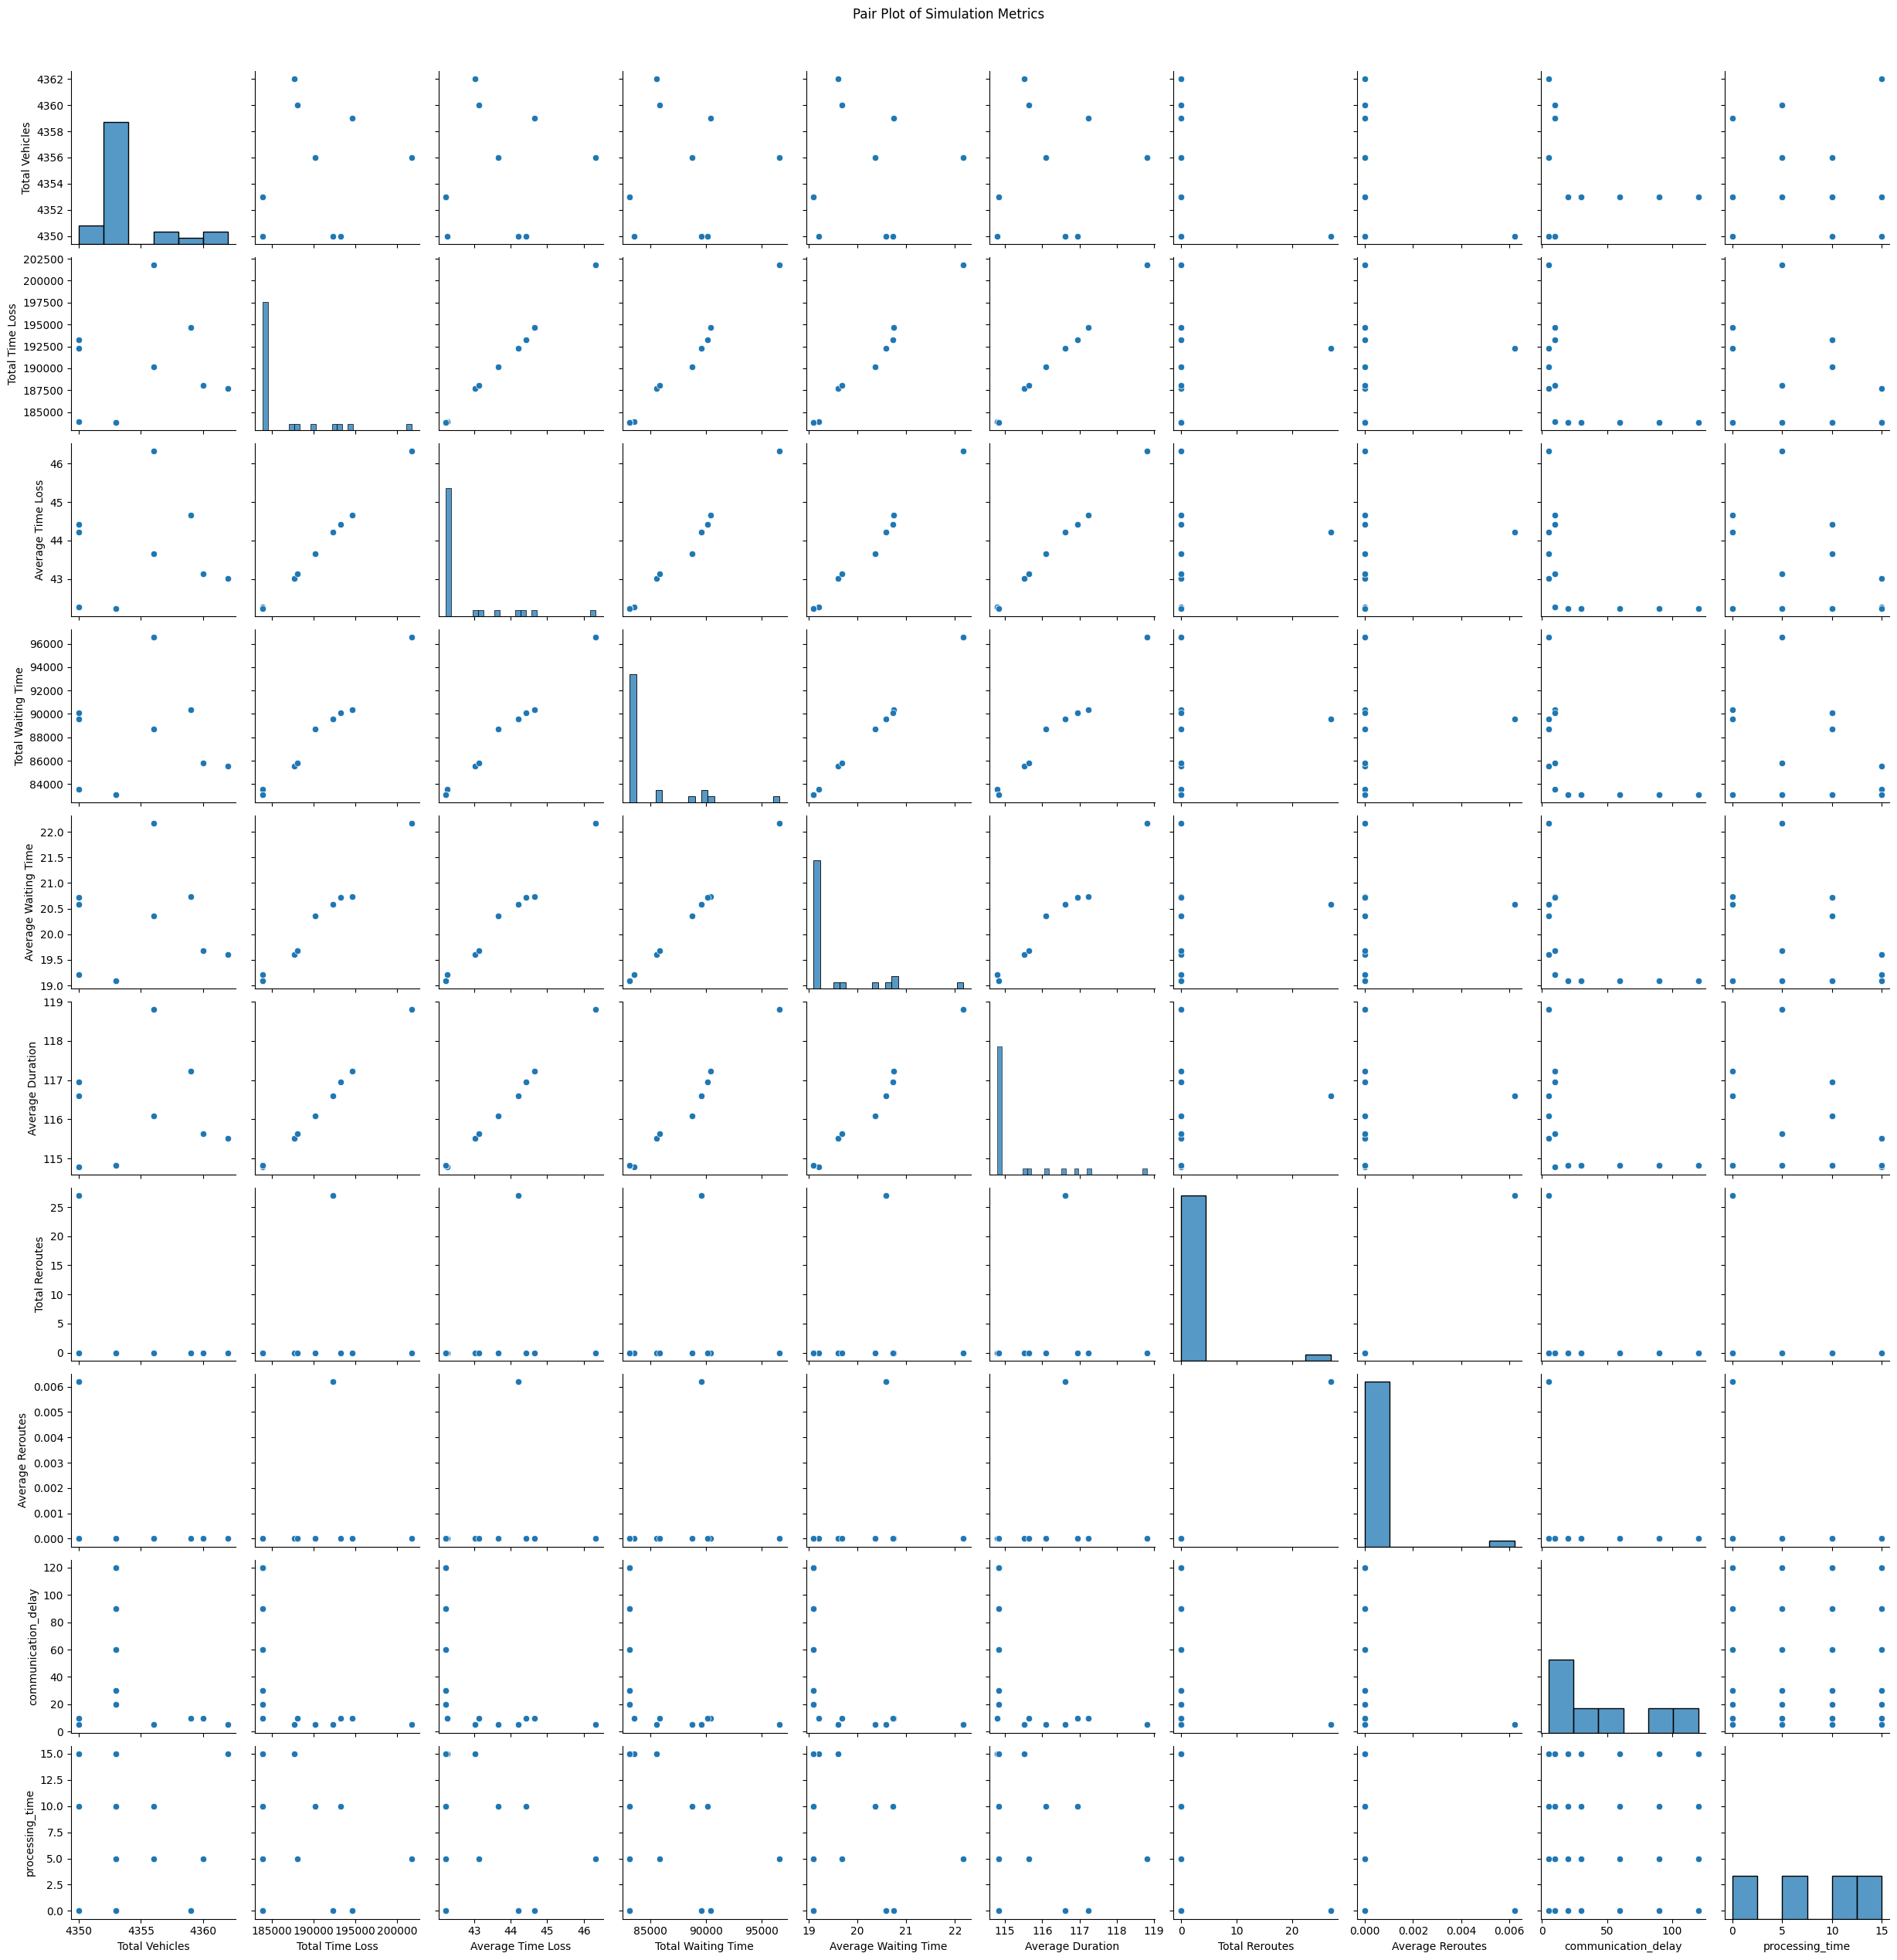

In [20]:
sns.pairplot(df)
plt.suptitle('Pair Plot of Simulation Metrics', y=1.02)
plt.show()